# Прогнозирование уровня средней зп в России

In [84]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from itertools import product
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [6]:
os.listdir('files')

['monthly-milk-production_1.csv',
 'monthly-australian-wine-sales.csv',
 'monthly-milk-production.csv',
 'WAG_C_M.csv']

In [7]:
#Загрузка файлов
sal = pd.read_csv('files/WAG_C_M.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
sal.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [8]:
sal.columns = ['salary']
sal = pd.DataFrame(sal)

## Визуализация ряда

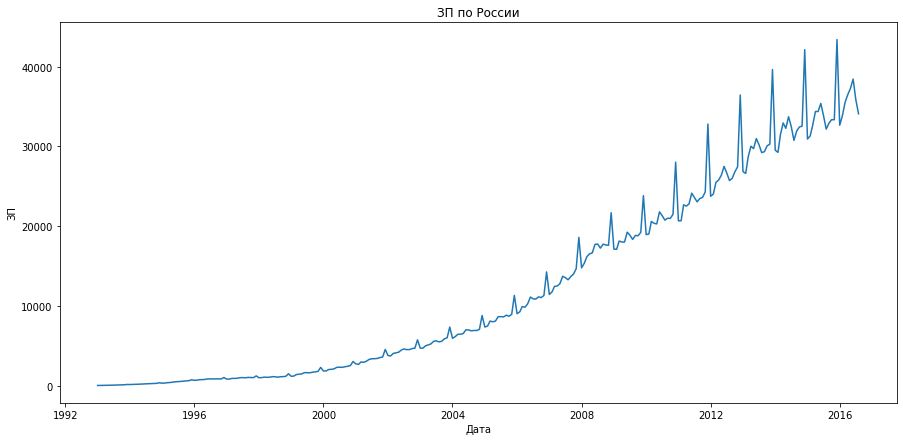

In [9]:
plt.figure(figsize=(15,7))
plt.plot(sal)
plt.ylabel('ЗП')
plt.xlabel('Дата')
plt.title('ЗП по России');

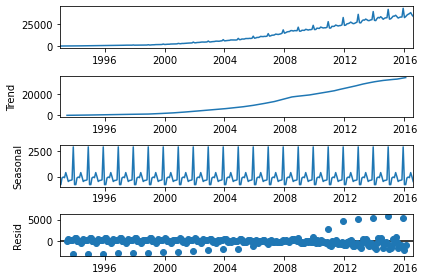

In [10]:
sm.tsa.seasonal_decompose(sal).plot();

Из графика видно что присутствует тренд, некоторая сезонность (пики в конце каждого года, скорее всего связано с выплатой премий в этот период)
Так же дисперсия ряда со временем увеличивается.
Исходя из этих наблюдений нужно будет сделать:
1. Стабилизацию дисперсии
2. Сезонное дифференцирование (убрать сезонность)
3. Простое дифференцирование (убрать тренд)

In [11]:
#Критерий Дики-Фуллера
print('p-value = {:.2f}'.format(adfuller(sal)[1]))

p-value = 0.99


Ряд не стационарен, присутствует тренд и сезонность

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584
Критерий Дики-Фуллера: p=0.696898763483269


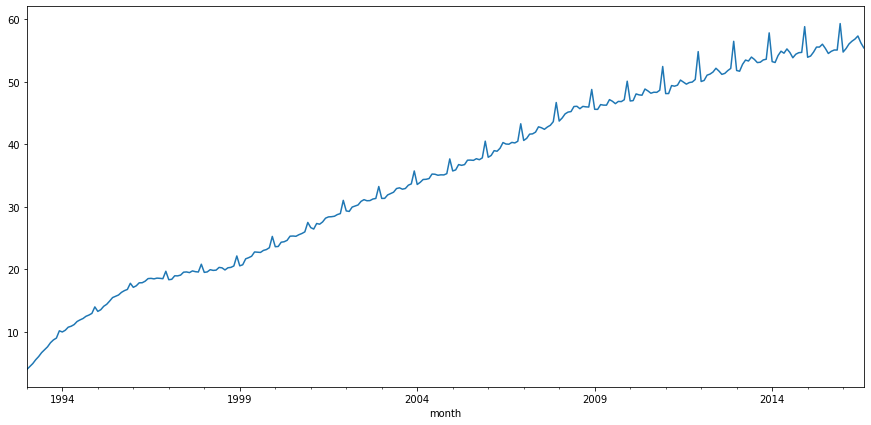

In [87]:
sal['salary_box'], lmbda = stats.boxcox(sal.salary)
plt.figure(figsize=(15,7))
print("Оптимальный параметр преобразования Бокса-Кокса: {}".format(lmbda))
print("Критерий Дики-Фуллера: p={}".format(adfuller(sal['salary_box'])[1]))
sal.salary_box.plot();

### Стационарность
Критерий Дики-Фуллера допускает гипотезу нестационарности, поэтому проведем сезонное дифференцирование

In [88]:
sal_dif12 = sal.salary_box - sal.salary_box.shift(12)
#sal_dif12 = sal.salary - sal.salary.shift(12)
sal_dif12.dropna(inplace=True)

<AxesSubplot:xlabel='month'>

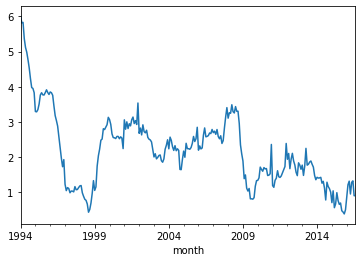

In [89]:
sal_dif12.plot()

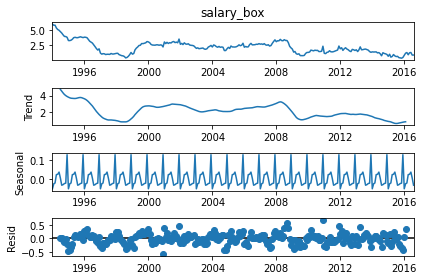

In [93]:
sm.tsa.seasonal_decompose(sal_dif12).plot();

In [90]:
print('p-value = {:.2f}'.format(adfuller(sal_dif12)[1]))

p-value = 0.01


по критерию Дики-Фуллера ряд стационарен, однако видно что присутствует тренд -  проведем обычное дифференцирование

p-value = 0.00


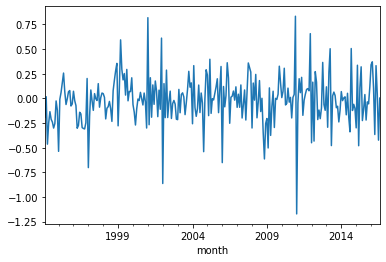

In [94]:
sal_difful = sal_dif12 - sal_dif12.shift(1)
sal_difful.dropna(inplace=True)
sal_difful.plot()
print('p-value = {:.2f}'.format(adfuller(sal_difful)[1]))

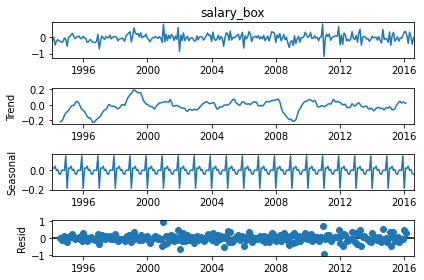

In [95]:
sm.tsa.seasonal_decompose(sal_difful).plot();

ряд стационарен

## Подбор модели


Посмотрим на ACF и PACF полученного ряда:

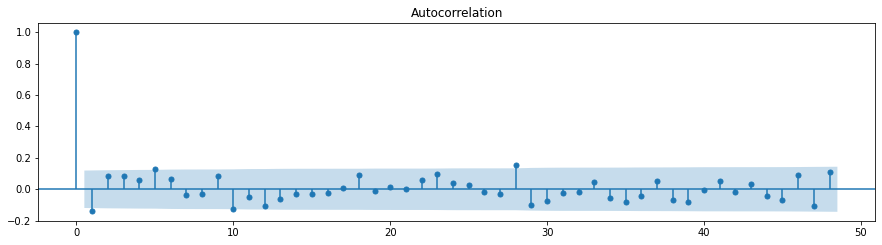

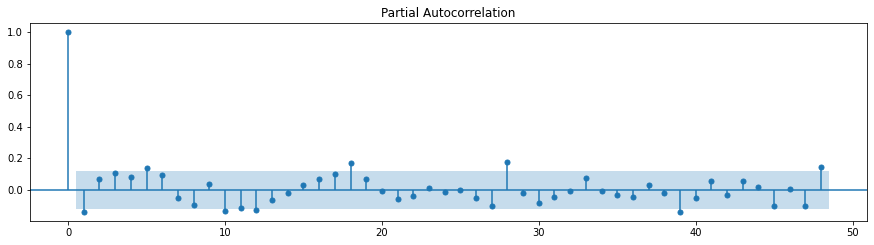

In [110]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(sal_difful.values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(sal_difful.values.squeeze(), lags=48, ax=ax)
plt.show()

In [111]:
#Начальные приблежения
q = 5
Q = 0
p = 5
P = 1

In [112]:
ps = range(p+1)
qs = range(q+1)
Ps = range(P+1)
Qs = range(Q+1)
d = 1
D = 1

In [113]:
Qs

range(0, 1)

In [114]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [115]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sal.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 5min 35s, sys: 8.2 s, total: 5min 43s
Wall time: 1min 27s


In [116]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
71  (5, 5, 1, 0) -25.144262
59  (4, 5, 1, 0) -22.474158
70  (5, 5, 0, 0) -21.826170
28  (2, 2, 0, 0) -21.488595
29  (2, 2, 1, 0) -21.473461


In [117]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.572
Date:                             Thu, 21 Oct 2021   AIC                            -25.144
Time:                                     00:37:59   BIC                             18.081
Sample:                                 01-01-1993   HQIC                            -7.789
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2144      1.062     -0.202      0.840      -2.296       1.867
ar.L2          0.2417      

Критерий Стьюдента: p=0.171926
Критерий Дики-Фуллера: p=0.000000


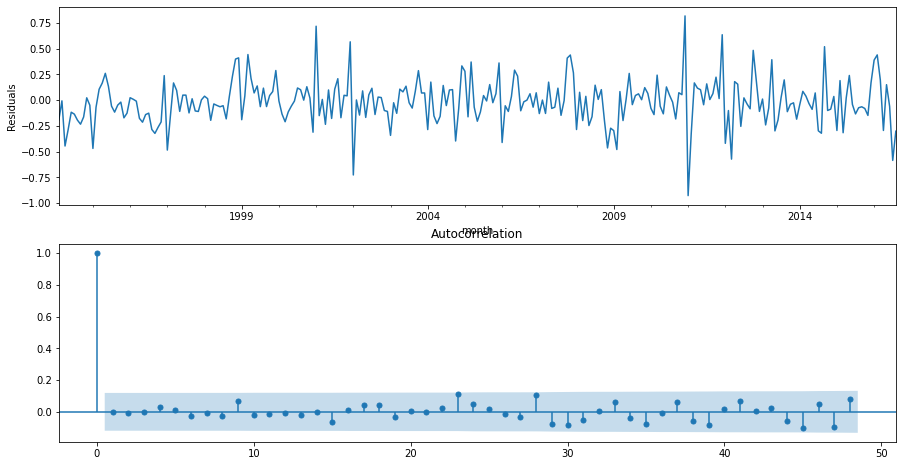

In [118]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера), неавтокоррелированы (подтверждается коррелограммой).

In [119]:
# обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Посмотрим как модель описывает данные

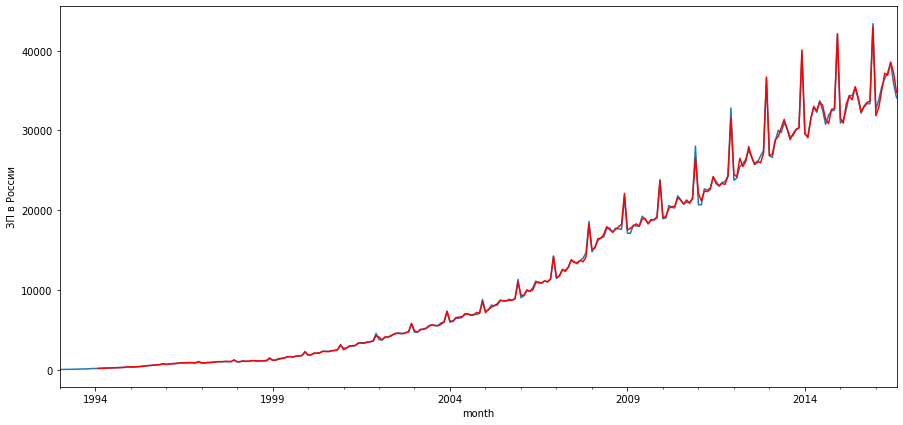

In [120]:
sal['model'] = invboxcox(best_model.fittedvalues, lmbda)
#sal['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
sal.salary.plot()
sal.model[13:].plot(color='r')
plt.ylabel('ЗП в России')
plt.show()

In [121]:
mean_absolute_error(sal['model'], sal.salary)

160.54351790688213

mae без стабилизации = 179.4933502401349 \
mae со стабилизацией = 160.54351790688213

## Построим прогноз

In [123]:
sal_2 = sal[['salary']]

In [124]:
date_list = [sal.index[-1] + relativedelta(months=x) for x in range(0,25)]

In [125]:
sal_2 = pd.concat([sal_2, pd.DataFrame(index=date_list)])

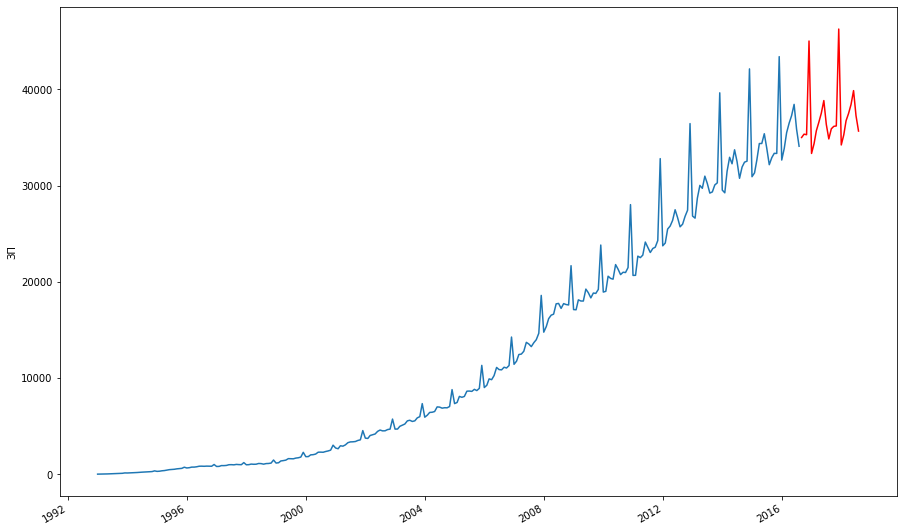

In [127]:
#wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)
sal_2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)
plt.figure(figsize=(15,10))
sal_2.salary.plot()
sal_2.forecast.plot(color='r')
plt.ylabel('ЗП')
plt.show()